# Mini neural net training
Authors: Alfredo Canziani, Philipp Schmitt  
Date: Tue 24 Feb 2020

In [2]:
import torch
from torch import nn, optim
from IPython import display
from PIL import Image, ImageFont, ImageDraw
from matplotlib.pyplot import imshow, axis, figure, subplot, pause
import numpy
import random

%matplotlib inline

In [3]:
# static random seed
torch.manual_seed(0)

In [4]:
# Input definition
class input_settings:
    batch_size = 1
    channels = 1
    height = 8
    width = 8

dummy_X = torch.randn(  # batch of inputs x
    input_settings.batch_size,
    input_settings.channels,
    input_settings.height,
    input_settings.width,
)

In [5]:
# Network architecture
class model_settings:
    conv_channels = 4
    kernel = 3
    pooling_kernel = 3
    flattened = 16
    output_size = 1
    
model = nn.Sequential(
    nn.Conv2d(
        in_channels=input_settings.channels,
        out_channels=model_settings.conv_channels,
        kernel_size=model_settings.kernel,
        bias=True,
    ),
    nn.ReLU(),
    nn.MaxPool2d(
        kernel_size=model_settings.pooling_kernel,
        stride=model_settings.pooling_kernel,
    ),  # we have 4 x 2x2
    nn.Flatten(),  # gives 16
    nn.Linear(
        in_features=model_settings.flattened,
        out_features=model_settings.output_size,
        bias=True,
    ),
)

In [6]:
# Inference
with torch.no_grad():
    print(model(dummy_X).size())

torch.Size([1, 1])


In [7]:
# Print the model architecture
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [8]:
# Get weights and biases
def get_weights():
    print(
        model[0],
        model[0].weight,
        model[0].bias,
        sep='\n',
    )
    print(
        model[4],
        model[4].weight,
        model[4].bias,
        sep='\n',
    )
    # Maybe add some saving routines

In [9]:
font = ImageFont.truetype('Verdana', 8)  # let's keep it to Verdana 8pt
data_set_settings = dict(
    D=dict(
        x_min = -1,
        x_max = 2,
        y_min = -3,
        y_max = -1,
    ),
    C=dict(
        x_min = 0,
        x_max = 3,
        y_min = -4,
        y_max = -2,
    )
)

In [10]:
def generate_data(visualise=False, target=None):
    image = Image.new('L', (input_settings.height, input_settings.width))
    draw = ImageDraw.Draw(image)
    draw.fontmode = '1'
    if not target:
        character = random.choice(('C', 'D'))
    else:
        character = target

    x = random.randint(
        data_set_settings[character]['x_min'],
        data_set_settings[character]['x_max'],
    )
    y = random.randint(
        data_set_settings[character]['y_min'],
        data_set_settings[character]['y_max'],
    )

    draw.text((x, y), character, (255,), font=font)
    data = numpy.array(image, dtype=numpy.float32) / 255
    
    if visualise:
        figure(facecolor='k')
        imshow(data, cmap='gray')
        axis('off');
    
    return torch.tensor(data).unsqueeze_(0), torch.tensor(character=='C', dtype=torch.float)

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor(1.))

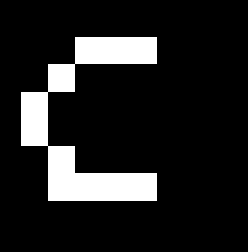

In [11]:
generate_data(visualise=True)

In [37]:
# letter samples
samples = [
    [
        [0,1,1,1],
        [1,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
        [0,1,1,1]
    ],
    [
        [1,1,1],
        [1,0,0],
        [1,0,0],
        [1,1,1]
    ],
    [
        [1,1,1,0],
        [1,0,0,1],
        [1,0,0,1],
        [1,0,0,1],
        [1,0,0,1],
        [1,1,1,0]
    ],
    [
        [1,1,0],
        [1,0,1],
        [1,0,1],
        [1,1,0]
    ]
]

sample_meta = [
    [6,4,'C'],
	[4,3,'C'],
	[6,4,'D'],
	[4,3,'D']
]

(tensor([[[0., 0., 0., 0., 1., 1., 1., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor(1.))

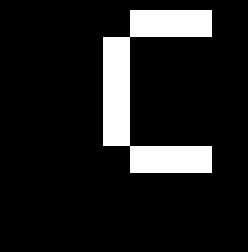

In [133]:
# updated gen. function to match teensy implementation
def generate_data(visualise=False, target=None):
    data = numpy.zeros(shape=(8,8), dtype=numpy.float32)
    
    sample = random.randint(0,len(samples)-1)
    character = sample_meta[sample][2];
    
    x = random.randint(
        0,
        input_settings.width-sample_meta[sample][1]
    )
    y = random.randint(
        0,
        input_settings.height-sample_meta[sample][0]
    )
    
    data[y:y+sample_meta[sample][0],x:x+sample_meta[sample][1]] = samples[sample]
    
    if visualise:
        figure(facecolor='k')
        imshow(data, cmap='gray')
        axis('off');
        
    return torch.tensor(data).unsqueeze_(0), torch.tensor(character=='C', dtype=torch.float)
        
generate_data(visualise=True)

In [134]:
# Generate a C, D batch
def get_batch(visualise=False):
    Cx, Cy = generate_data(target='C', visualise=visualise)
    Dx, Dy = generate_data(target='D', visualise=visualise)
    x = torch.stack((Cx, Dx))
    y = torch.stack((Cy, Dy))
    return x, y

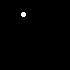

In [138]:
from PIL import Image, ImageDraw
from numpy import interp
from math import cos, sin, radians, pi


def draw_weight(value, size=20):
    rad = interp(value,[-.75,.75],[pi,0])
    im = Image.new('RGB', (size, size), (0, 0, 0))
    draw = ImageDraw.Draw(im)
    x, y, r = (
        size/2 + size/3 * cos(rad), 
        size/2 - size/3 * sin(rad),
        4)
    draw.ellipse((x-r/2, y-r/2, x+r/2, y+r/2), fill=(255, 255, 255), outline=None)

    return im

draw_weight(-.25, 70)

In [139]:
# draw weights

def draw_weights(layer, size=20):
    weights = layer.weight.data.clone().numpy()

    n_weights = len(weights[0])
    im = Image.new('RGB', ((size+1)*n_weights, size), (255, 255, 255))

    for i in range(n_weights):
        weight = draw_weight(weights[0][i], size=size)
        im.paste(weight,((size+1)*i,0))

    return im

draw_weights(model[4], size=30)

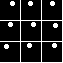

In [140]:
# draw a filter
def draw_filter(filter):
    matrix = Image.new('RGB', (63, 63), (255, 255, 255))
    data = filter.view(3, 3).numpy()
    # go over filter
    # rows
    for x in range(0, data.shape[0]):
        # cols
        for y in range(0, data.shape[1]):
            vis = draw_weight(data[y,x])
            matrix.paste(vis,(x*21,y*21))
    return matrix

filters = model[0].weight.data
draw_filter(filters[0])

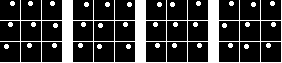

In [141]:
# draw all filters
def draw_filters(layer):
    matrix = Image.new('RGB', (282, 63), (255, 255, 255))
    filters = layer.weight.data.clone()
    for i, filter in enumerate(filters):
        vis = draw_filter(filter)
        matrix.paste(vis, (i*(63+10),0))
    return matrix


draw_filters(model[0])

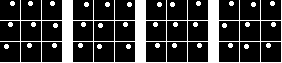

In [142]:
draw_filters(model[0])

In [143]:
#model[0].weight.data.fill_(0)
#model[4].weight.data.fill_(0)

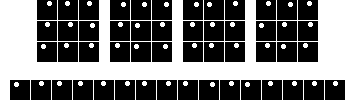

In [144]:
# draw all the weights in the net
def draw_net():
    im = Image.new('RGB', (356, 100), (255, 255, 255))
    im.paste(draw_filters(model[0]), (37,0))
    im.paste(draw_weights(model[4]), (10,80))

    return im

draw_net()

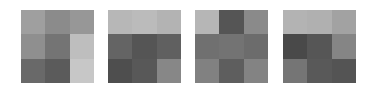

In [147]:
# Visualize weights
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    # visualize
    for i in range(0, len(filters)):
        data = filters[i].view(3, 3)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');
        
visualize_filters(model[0])

---
# Training

In [196]:
# Set up network training
nb_epochs = 10_000
optimiser = optim.SGD(params=model.parameters(), lr=1e-4)
#loss = nn.BCEWithLogitsLoss()
loss = nn.BCEWithLogitsLoss()

[EPOCH]: 6000, [LOSS]: 0.446537, [ACCURACY]: 1.000
tensor([[[[ 0.2568,  0.1104,  0.1673],
          [ 0.1286, -0.1042,  0.5102],
          [-0.1522, -0.2983,  0.5759]]],


        [[[ 0.4487,  0.4797,  0.4105],
          [-0.2344, -0.3460, -0.2620],
          [-0.3920, -0.3163,  0.0459]]],


        [[[ 0.4300, -0.3331,  0.0822],
          [-0.1247, -0.1019, -0.1554],
          [ 0.0019, -0.2639,  0.0248]]],


        [[[ 0.4221,  0.3933,  0.2805],
          [-0.4267, -0.3325,  0.0364],
          [-0.0886, -0.3105, -0.3442]]]])


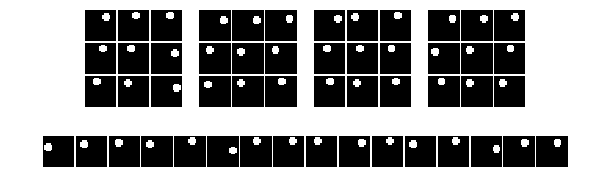

KeyboardInterrupt: 

In [197]:
# Training
for epoch in range(nb_epochs):
    # Training steps
    X, Y = generate_data()
    logits = model(X.unsqueeze(0))  # feed-forward
    
    # not sure if I'm doing this right ...
    logits = logits.squeeze(-2)
    Y = Y.unsqueeze(0)

    J = loss(logits, Y)  # computes the loss
    model.zero_grad()  # cleans up previous gradients
    J.backward()
    optimiser.step()
    
    # Accuracy computation and display
    score, predicted = torch.max(logits, 0)
    acc = (Y == (logits > 0)).sum().float() / len(Y)

    if(epoch % 100 == 0):
        display.clear_output(wait=True)
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, J.item(), acc))
        
        print(model[0].weight.data)
        
        figure(figsize=(10, 20))
        #visualize_filters(model[0])
        im = draw_net()
        imshow(numpy.asarray(im), aspect='equal', interpolation='nearest')
        
        # im.save('%s.png' % epoch)
        
        #draw_filters(model[0]).save('%i.png' % epoch)
        axis('off');
        pause(0.1)

C


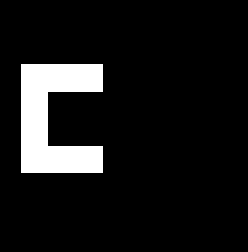

In [236]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=True)[0].unsqueeze_(0)) > 0 else 'D')

In [237]:
# register hook to get activation after conv layer out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model[0].register_forward_hook(get_activation('act'))
model[1].register_forward_hook(get_activation('relu'))
model[2].register_forward_hook(get_activation('pool'))
model[3].register_forward_hook(get_activation('flatten'))

D
tensor([[[[ 2.4630e-01,  2.4630e-01,  2.4630e-01,  2.4630e-01,  2.4630e-01,
            2.4630e-01],
          [ 2.4630e-01,  2.4630e-01,  2.4630e-01,  2.4630e-01,  2.4630e-01,
            2.4630e-01],
          [ 2.4630e-01,  2.4630e-01,  8.2236e-01,  5.2409e-01, -2.0414e-01,
            9.4129e-02],
          [ 2.4630e-01,  2.4630e-01,  1.3327e+00,  3.5409e-01,  6.9464e-01,
            7.6730e-02],
          [ 2.4630e-01,  2.4630e-01,  1.5001e+00,  1.2165e-01,  1.6766e+00,
            1.0067e-01],
          [ 2.4630e-01,  2.4630e-01,  1.5001e+00,  5.3033e-01,  8.5915e-01,
            1.0036e-01]],

         [[ 2.4893e-01,  2.4893e-01,  2.4893e-01,  2.4893e-01,  2.4893e-01,
            2.4893e-01],
          [ 2.4893e-01,  2.4893e-01,  2.4893e-01,  2.4893e-01,  2.4893e-01,
            2.4893e-01],
          [ 2.4893e-01,  2.4893e-01,  2.9484e-01, -2.1504e-02, -4.5946e-01,
           -1.4312e-01],
          [ 2.4893e-01,  2.4893e-01,  3.2814e-02, -6.7547e-01, -6.7775e-01,
           

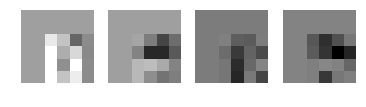

In [238]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=False)[0].unsqueeze_(0)) > 0 else 'D')
    print(activation['act'])
    
    # visualize activations after convolution
    for i, act in enumerate(activation['act'][0]):
        print(act)
        data = act.view(6,6)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');

---
# A printout of sample data, activations, outputs to troubleshoot Teensy implementation

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])


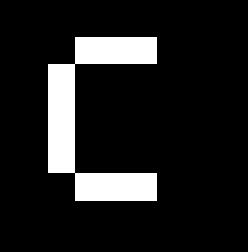

In [239]:
dat = generate_data(visualise=True, target="D")
dat = dat[0].unsqueeze_(0)
print(dat)

In [240]:
get_weights()

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
Parameter containing:
tensor([[[[ 0.2569,  0.1105,  0.1674],
          [ 0.1287, -0.1043,  0.5103],
          [-0.1522, -0.2983,  0.5761]]],


        [[[ 0.4487,  0.4797,  0.4105],
          [-0.2345, -0.3460, -0.2620],
          [-0.3920, -0.3163,  0.0459]]],


        [[[ 0.4300, -0.3331,  0.0822],
          [-0.1247, -0.1019, -0.1554],
          [ 0.0019, -0.2639,  0.0248]]],


        [[[ 0.4221,  0.3933,  0.2805],
          [-0.4268, -0.3325,  0.0364],
          [-0.0887, -0.3105, -0.3442]]]], requires_grad=True)
Parameter containing:
tensor([ 0.2463,  0.2489, -0.0247,  0.0242], requires_grad=True)
Linear(in_features=16, out_features=1, bias=True)
Parameter containing:
tensor([[-0.5481, -0.3763, -0.2324, -0.3884,  0.1324,  0.7295,  0.0358,  0.1847,
         -0.1555,  0.3133,  0.0970, -0.3748,  0.1187,  0.6135,  0.2777,  0.2629]],
       requires_grad=True)
Parameter containing:
tensor([0.1862], requires_grad=True)


C
tensor([[ 0.4583,  0.5002,  0.7811,  0.2707,  0.3750,  0.2463],
        [ 0.0112,  0.5007,  0.7811,  0.6137,  0.5032,  0.2463],
        [-0.0457,  0.4797,  0.2463,  0.2463,  0.2463,  0.2463],
        [-0.0457,  0.4797,  0.2463,  0.2463,  0.2463,  0.2463],
        [ 0.8286,  0.9097,  0.3719, -0.2041,  0.0941,  0.2463],
        [ 0.8671,  0.9093,  0.7811,  0.2707,  0.3750,  0.2463]])
tensor([[-0.3294, -0.7512, -0.5936, -0.3316,  0.0144,  0.2489],
        [-0.0030,  0.5125,  1.5878,  1.1773,  0.6976,  0.2489],
        [ 0.0662,  0.0711,  0.2489,  0.2489,  0.2489,  0.2489],
        [ 0.0662,  0.0711,  0.2489,  0.2489,  0.2489,  0.2489],
        [ 0.4285,  0.1927, -0.4136, -0.4595, -0.1431,  0.2489],
        [ 0.4666,  0.0896, -0.5936, -0.3316,  0.0144,  0.2489]])
tensor([[-0.4440, -0.2802, -0.4067, -0.2513, -0.1494, -0.0247],
        [-0.3083, -0.3984,  0.1544,  0.0722,  0.4053, -0.0247],
        [-0.7235,  0.2825, -0.0247, -0.0247, -0.0247, -0.0247],
        [-0.7235,  0.2825, -0.0247, 

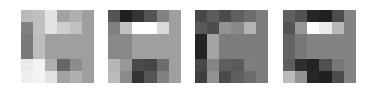

In [241]:
with torch.no_grad():
    #dat = generate_data(visualise=False)
    print('C' if model(dat) > 0 else 'D')
    
    # visualize activations after convolution
    for i, act in enumerate(activation['act'][0]):
        print(act)
        data = act.view(6,6)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');
    
    print("\n")
    
    print("relu:")
    print(activation["relu"])
    print("\n")
    
    print("pool:")
    print(activation["pool"])
    print("\n")
    
    print("flatten:")
    print(activation["flatten"])
    print("\n")
    
    